In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [58]:
data = np.load('../../../source_synphot/caspec_mags.npy',allow_pickle=True).item()
data = pd.DataFrame(data)
red = np.load('../../../source_synphot/caspec_mags_av3p1.npy',allow_pickle=True).item()
red = pd.DataFrame(red)
# restrict to the MS section of the stellar locus
ind = (data['r'].values-data['i'].values) < 0.3
#data = data.iloc[ind]

good = []
for i in range(len(data['name'])):
    if 'ngc6681' not in data['name'].iloc[i]:
        good += [i]
good = np.array(good)
data = data.iloc[good]
gr = data['g'].values-data['r'].values
ind = (gr < 1)
data = data.iloc[ind]

## assume zeropoint of 25

In [3]:
def mag2flux(mag,zp):
    f = 10**(2/5*(zp-mag))
    return f

In [59]:
zp = 25
g = mag2flux(data['g'].values,zp)
r = mag2flux(data['r'].values,zp)
i = mag2flux(data['i'].values,zp)
z = mag2flux(data['z'].values,zp)
y = mag2flux(data['y'].values,zp)
k = mag2flux(data['kep'].values,zp)
t = mag2flux(data['tess'].values,zp)

<IPython.core.display.Javascript object>


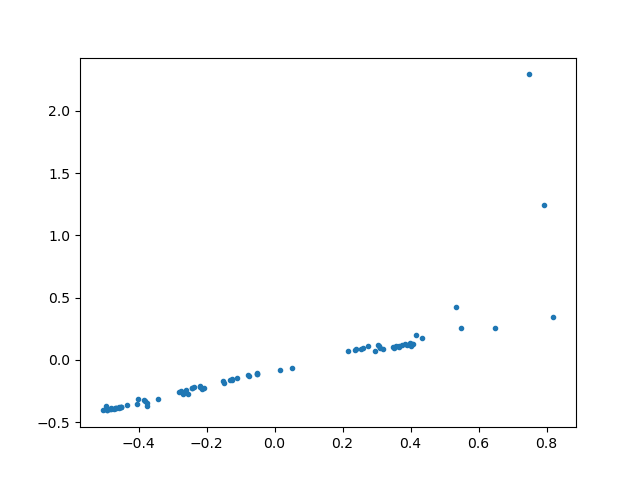

In [20]:
plt.figure()
plt.plot(data['g']-data['r'],data['r']-data['i'],'.')

In [174]:

def t_linear_combo(c,mag):
    g = mag2flux(data['g'],zp)
    r = mag2flux(data['r'],zp)
    i = mag2flux(data['i'],zp)
    z = mag2flux(data['z'],zp)
    y = mag2flux(data['y'],zp)
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y + c[5]*(g-r)
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y)*(g/i)**c[5]
    return fit 

def t_minimizer(c,mag):
    k = data['tess']
    fit = -2.5*np.log10(t_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    #print(res)
    return res

def k_linear_combo(c,mag):
    g = mag2flux(data['g'],zp)
    r = mag2flux(data['r'],zp)
    i = mag2flux(data['i'],zp)
    z = mag2flux(data['z'],zp)
    #old
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*(g-r)
    #new
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z)*(g/i)**c[4]
    return fit 

def k_minimizer(c,mag):
    k = data['kep']
    fit = -2.5*np.log10(k_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

def r_linear_combo(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    return fit 

def r_comp(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518 # 3.629
        re = ext * 2.617 # 2.611
        ie = ext * 1.971 # 1.935
        ze = ext * 1.549 # 1.523
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    r = -2.5*np.log10(fit) + 25 + re
    return r


def r_linear_combo2(c,mag):
    g = mag2flux(mag['g'],zp)
    i = mag2flux(mag['i'],zp)
    fit = (0.5*g + 0.5*i)*(g/i)**c[0]
    return fit 

def r_minimizer(c,mag):
    k = data['r']
    fit = -2.5*np.log10(r_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

In [8]:
thing = pd.DataFrame(data)

In [23]:
c0 = [.25,.25,.25,.25,.25,1]
bds = [(0,1),(0,1),(0,1),(0,1),(0,1),(-100,100)]
res = minimize(t_minimizer,c0,args=thing,bounds=bds)

In [24]:
res

      fun: 0.14531150756387134
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.07272561,  0.44316817,  0.00947171,  1.64242007,  3.80812502,
       -0.81482181])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 812
      nit: 49
     njev: 116
   status: 0
  success: True
        x: array([0.        , 0.23482658, 0.35265516, 0.27569384, 0.13800082,
       0.00067772])

In [25]:
cr = 0.23482658
ci = 0.35265516
cz = 0.27569384
cy = 0.13800082

In [13]:
cr+ci+cz+cy

1.0011764

In [26]:
def t_linear_combo(c,ps1):
    cg = 0
    cr = 0.23482658
    ci = 0.35265516
    cz = 0.27569384
    cy = 0.13800082
    cp = 0.00067772
    fit = ((cg*ps1['g'] + cr*ps1['r'] + ci*ps1['i'] + 
            cz*ps1['z'] + cy*ps1['y'])*(ps1['g']/ps1['i'])**cp)
    return fit 

In [36]:
test = t_linear_combo(res.x,data)

In [37]:
data

,g,r,i,z,y,kep,tess,name
0,16.448833,16.824855,17.193941,17.469483,17.703807,16.787205,17.207572,hs2027_stis_005
1,9.278681,9.771373,10.171662,10.469041,10.688448,9.689357,10.184255,bd_75d325_stis_005
2,16.984610,17.193064,17.418678,17.571332,17.448099,17.171691,17.387602,sdss132811_stis_003
3,14.527466,13.733931,12.486512,11.917067,11.668695,13.262748,12.340525,hz43b_stis_005
4,7.962748,7.644969,7.559345,7.557648,7.557790,7.703916,7.576215,hd38949_stis_005
...,...,...,...,...,...,...,...,...
86,7.483706,7.563091,7.683774,7.763686,7.780774,7.569961,7.686185,hd2811_stis_002
87,20.219263,19.471891,17.180642,15.592554,14.568557,17.924898,15.953766,2m003618_stiswfcnic_003
88,16.211254,16.669703,17.047354,17.349198,17.574212,16.597501,17.069956,wd1657_343_stiswfcnic_003
89,12.225922,12.374392,12.560075,12.734734,12.875551,12.376653,12.590816,gj7541a_stis_004


In [38]:
test = -2.5*np.log10(test) + 25
#m = sigm

<IPython.core.display.Javascript object>


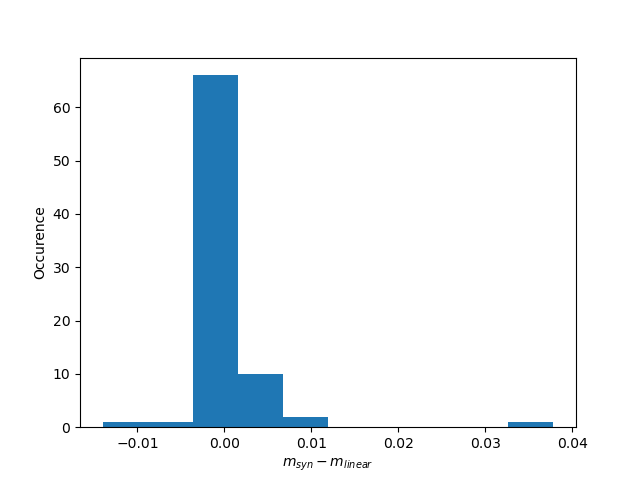

Text(0, 0.5, 'Occurence')

In [39]:
plt.figure()
plt.hist(thing['tess']-test,bins=10)
plt.xlabel(r'$m_{syn}-m_{linear}$')
plt.ylabel('Occurence')

<IPython.core.display.Javascript object>


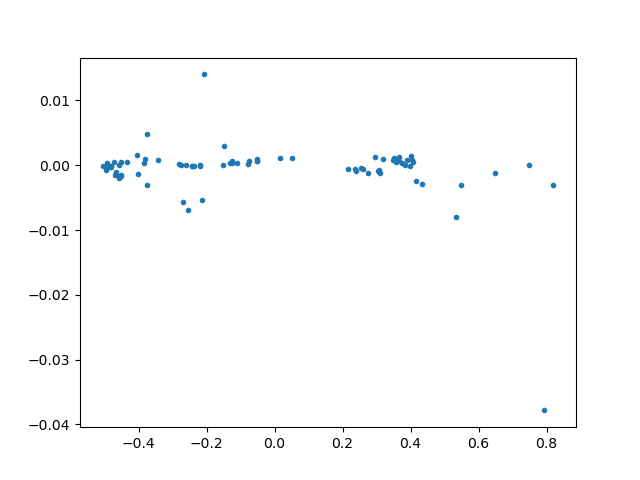

In [40]:
plt.figure()
plt.plot(data['g']-data['r'],test-data['tess'],'.')
#plt.plot(data['r']-data['i'],data['tess'],'.')
#plt.yscale('log')

<IPython.core.display.Javascript object>


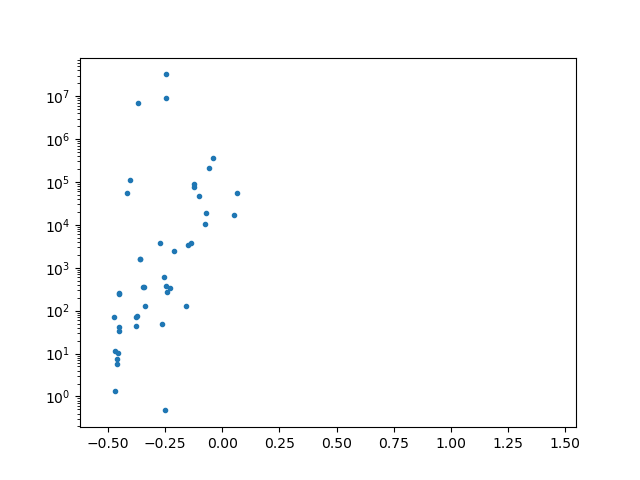

In [97]:
plt.figure()
plt.plot(data['g']-data['r'],k-test,'.')
#plt.plot(data['g']-data['r'],test,'.')
plt.yscale('log')

# Kepler

In [134]:
zp = 25
c0 = [.25,.25,.25,.25,1]
bds = [(0,1),(0,1),(0,1),(0,1),(-100,100)]
thing = pd.DataFrame(data)
res = minimize(k_minimizer,c0,args=thing,bounds=bds)

In [135]:
res

      fun: 0.14206856303302828
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.62218931, 3.21768123, 3.11390114, 2.73715486, 1.36400402])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 768
      nit: 47
     njev: 128
   status: 0
  success: True
        x: array([0.22009087, 0.43310106, 0.2863363 , 0.0638597 , 0.08108538])

In [433]:
0.37529951+  0.37586262+  0.19070184+0.05867781

1.00054178

In [136]:
test = k_linear_combo(res.x,data)
redtest = k_linear_combo(res.x,red)

In [137]:
test = -2.5*np.log10(test) + 25
redtest = -2.5*np.log10(redtest) + 25

In [138]:
from astropy.stats import sigma_clip
diff = data['kep']-test
reddiff = red['kep']-redtest
gr = data['g'].values-data['r'].values
ind = ~sigma_clip(diff).mask

In [139]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

<IPython.core.display.Javascript object>


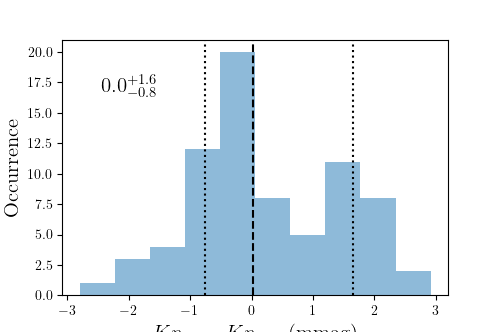

Text(0.1, 0.8, '$0.0^{+1.6}_{-0.8}$')

In [142]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(diff[ind]) - np.nanmin(diff[ind]) /(2*iqr(diff[ind])*len(diff[ind])**(-1/3)))
plt.hist(diff[ind]*1e3,bins=10,alpha=0.5)
plt.xlabel(r'$Kp_{cal}-Kp_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
med = np.nanmedian(diff[ind]*1e3)
low = np.percentile(diff[ind]*1e3,16)
high = np.percentile(diff[ind]*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,1))+'^{+' + str(np.round(high-med,1))+'}_{'+str(np.round(low-med,1))+'}$'
plt.annotate(s,(.1,.8),fontsize=15,xycoords='axes fraction')
#plt.savefig('PS1_com_residuals.pdf', bbox_inches = "tight")

<IPython.core.display.Javascript object>


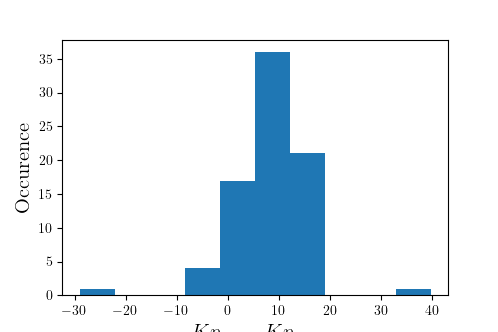

Text(0, 0.5, 'Occurence')

In [88]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.hist(reddiff,bins=10)
plt.xlabel(r'$Kp_{cal}-Kp_{com}$',fontsize=15)
plt.ylabel('Occurence',fontsize=15)
#plt.savefig('PS1_com_residuals.pdf', bbox_inches = "tight")

In [289]:
np.nanmean(diff[ind])

0.00016482681332488584

In [278]:
np.nanstd(diff[ind])

0.0017669649892862625

In [269]:
np.nanstd(diff[ind])

0.0011050932415813922

# $\chi^2$ value

In [290]:
np.nansum((diff)**2/np.std(diff)**2)/len(test)

1.0240628894678552

<IPython.core.display.Javascript object>


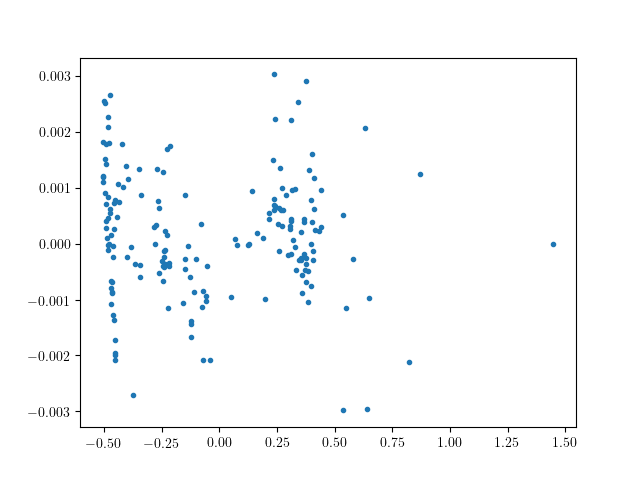

In [291]:
plt.figure()
plt.plot(gr[ind],diff[ind],'.')
plt.
#plt.plot(data['r']-data['i'],data['tess'],'.')
#plt.yscale('log')

# Test on r band

In [143]:
c0 = [.3,.3,.3,0]
bds = [(0,1),(0,1),(0,1),(-100,100)]
#c0 = [.1]
#bds = [(-100,100)]
thing = pd.DataFrame(data)
#thing = thing.iloc[ri<.38]
res = minimize(r_minimizer,c0,args=thing,bounds=bds)

In [144]:
res

      fun: 1.9818562727138644
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.94364512, 4.57031406, 5.71063908, 2.25273365])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 485
      nit: 26
     njev: 97
   status: 0
  success: True
        x: array([0.05881705, 0.66085622, 0.35021584, 0.37704977])

In [145]:
test = r_linear_combo(res.x,data)
test = -2.5*np.log10(test) + 25
rdiff = data['r']-test
gr = data['g'].values-data['r'].values
ri = data['r'].values-data['i'].values
control = (data['r']-data['i']).values
mask = ~sigma_clip(rdiff).mask
rdiff = rdiff[mask]

In [149]:
b

3

<IPython.core.display.Javascript object>


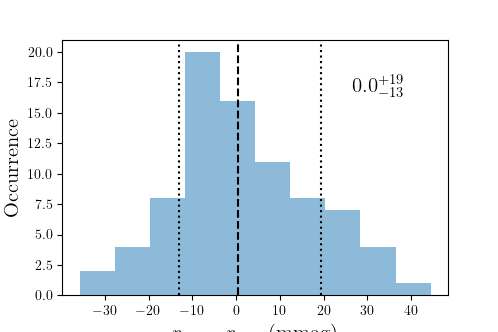

Text(0, 0.5, 'Occurrence')

In [150]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(rdiff) - np.nanmin(rdiff) /(2*iqr(rdiff)*len(rdiff)**(-1/3)))
plt.hist(rdiff*1e3,bins=10,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(rdiff*1e3,50)
low = np.percentile(rdiff*1e3,16)
high = np.percentile(rdiff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str((np.round(med,0)))+'^{+' + str(int(np.round(high-med,0)))+'}_{'+str(int(np.round(low-med,0)))+'}$'
plt.annotate(s,(.75,.8),fontsize=15,xycoords='axes fraction')

plt.xlabel(r'$r_{cal}-r_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
#plt.savefig('PS1_com_r_res.pdf', bbox_inches = "tight")

In [130]:
res.x

array([0.05881705, 0.66085622, 0.35021584, 0.37704977])

<IPython.core.display.Javascript object>


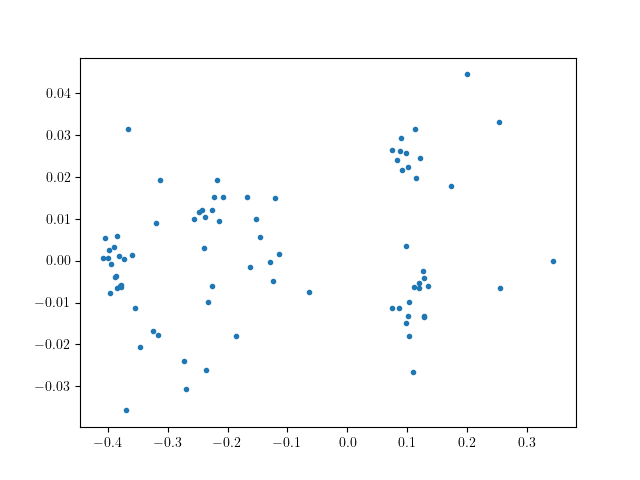

In [99]:
plt.figure()
plt.plot(ri[mask],rdiff,'.',label='r')

<IPython.core.display.Javascript object>


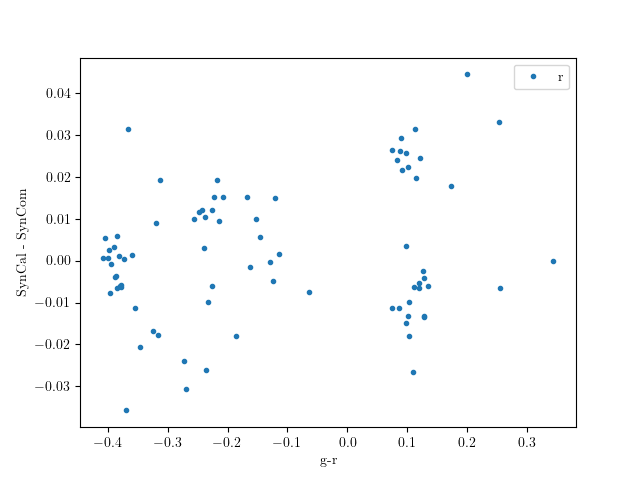

In [152]:
plt.figure()
plt.plot(ri[mask],rdiff,'.',label='r')
#plt.plot(gr,kdiff,'.',label='kep')
plt.xlabel('g-r')
plt.ylabel('SynCal - SynCom')
plt.legend()
plt.savefig('r_composite.png')

In [495]:
np.where((ri > .38) & (ri < 0.45))

(array([  2,  17,  19,  31,  32,  37,  49,  50,  66,  68,  86, 137, 163,
        193, 194]),)

In [66]:
eh = pd.read_csv('../../../calibration/calspec_coords.csv')

In [65]:
eh.to_csv('../../../calibration/calspec.csv',index=False)

# test red on sources

In [100]:
import sys
sys.path.append('../../../source_synphot/')
from tools import *

In [166]:
obs = pd.read_csv('../../../calibration/kepler/K2_all_PS1_psc_ev_crowding.csv')
obs = pd.read_csv('../../../source_synphot/K2_all_PS1_psc_ev_crowding_sdss_gaia.csv')

obs = obs.iloc[(obs['PDC'].values > 0)]

obs['kMeanPSFMag'] = -2.5*np.log10(obs['PDC'].values)
obs['kMeanPSFMagErr'] = 0.01#(-2.5 / np.log(10)) * (obs['PDCe'].values / obs['PDC'].values) #0.05#np.abs(obs['PDCe'].values) / np.abs(obs['PDC'].values)/10
#obs = obs.iloc[abs(obs['kMeanPSFMagErr'].values) < 0.1] 
diff = abs(obs['rMeanPSFMag'].values - obs['crMeanPSFMag'].values)
ind = diff < 1

obs = obs.iloc[ind]

ind = ((abs(obs['zMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['gMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['rMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['iMeanPSFMagErr'].values) < 0.5))
obs = obs.iloc[ind]
cind =  ((obs['campaign'].values == 16))
c16 = obs.iloc[cind]

cind =  ((obs['campaign'].values == 4))
c2 = obs.iloc[cind]

c4ext = np.load('../../../source_synphot/c4_ext.npy')
#ex, obs = Tonry_reduce(obs)

In [167]:
g = obs['gMeanPSFMag'].values
r = obs['rMeanPSFMag'].values
i = obs['iMeanPSFMag'].values
z = obs['zMeanPSFMag'].values

ind = (g-r < 0.9)
dist = obs.iloc[ind]
obs = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

g = c16['gMeanPSFMag'].values
r = c16['rMeanPSFMag'].values
i = c16['iMeanPSFMag'].values
z = c16['zMeanPSFMag'].values

ind = (g-r < 0.9)
d16 = c16.iloc[ind]
c16 = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

g = c2['gMeanPSFMag'].values
r = c2['rMeanPSFMag'].values
i = c2['iMeanPSFMag'].values
z = c2['zMeanPSFMag'].values

ind = (g-r < 0.9)
d2 = c2.iloc[ind]
c2 = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

In [103]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u

In [168]:
bayestar = BayestarQuery()
coords = SkyCoord(dist.RAJ2000.values*u.deg,dist.DecJ2000.values*u.deg,
                  distance=dist.gaia_med.values*u.pc, frame='icrs')
medall = bayestar(coords, mode='median')

coords = SkyCoord(d16.RAJ2000.values*u.deg,d16.DecJ2000.values*u.deg,
                  distance=d16.gaia_med.values*u.pc, frame='icrs')
med16 = bayestar(coords, mode='median')

coords = SkyCoord(d2.RAJ2000.values*u.deg,d2.DecJ2000.values*u.deg,
                  distance=d2.gaia_med.values*u.pc, frame='icrs')
med2 = bayestar(coords, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 29.312 s
  pix_info:   0.418 s
   samples:  18.634 s
      best:   4.308 s
       nan:   0.140 s
      sort:   5.675 s
       idx:   0.138 s


<IPython.core.display.Javascript object>


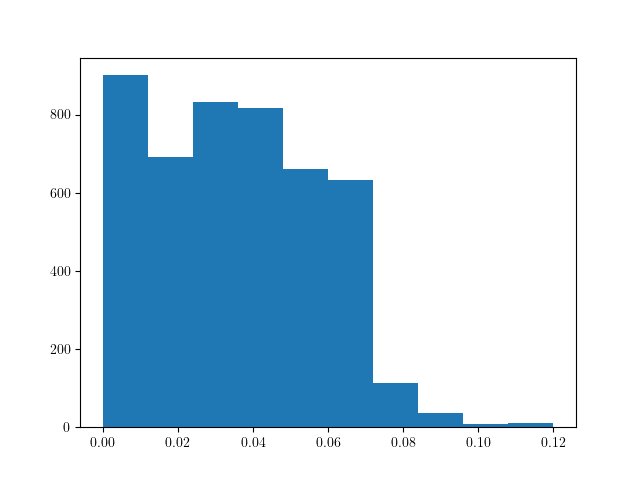

(array([901., 691., 832., 817., 662., 632., 112.,  36.,   9.,  12.]),
 array([0.   , 0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096,
        0.108, 0.12 ], dtype=float32),
 <BarContainer object of 10 artists>)

In [163]:
plt.figure()
plt.hist(med16)

In [46]:
from copy import deepcopy

In [171]:
why = np.array([0.0305,1,0.0132,0.3558])

In [175]:
test = r_comp(res.x,obs,medall)
#eh = r_comp(res.x,obs)
diff = (deepcopy(obs['r'])-test)#*1e3
#eh = (deepcopy(obs['r'])-eh)#*1e3
m = ~sigma_clip(diff).mask

test = r_comp(res.x,c16,med16)
diff16 = (c16['r']-test)#*1e3
m16 = ~sigma_clip(diff16).mask

test = r_comp(res.x,c2,med2)
diff2 = (c2['r']-test)#*1e3
m2 = ~sigma_clip(diff2).mask

In [48]:
from scipy.stats import iqr

In [127]:
medall

array([       nan, 0.32      , 0.95106024, ..., 0.05      , 0.05      ,
       0.03      ], dtype=float32)

<IPython.core.display.Javascript object>


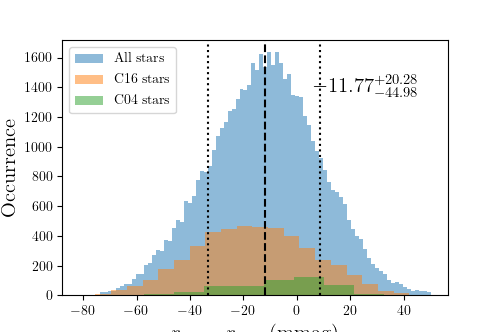

Text(0.5, 0, '$r_{obs}-r_{com}$ (mmag)')

In [176]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int((np.nanmax(diff[m]) - np.nanmin(diff[m])) /(2*iqr(diff[m])*len(diff[m])**(-1/3)))
a = plt.hist(diff[m]*1e3,bins=b, alpha=0.5,label='All stars')
#plt.axvspan(low,high,alpha = .3,color='orange')

b = int(np.nanmax(diff16[m16]) - np.nanmin(diff16[m16]) /(2*iqr(diff16[m16])*len(diff16[m16])**(-1/3)))
a = plt.hist(diff16[m16]*1e3,bins=b, alpha=0.5,label='C16 stars')

b = int(np.nanmax(diff2[m2]) - np.nanmin(diff2[m2]) /(2*iqr(diff2[m2])*len(diff2[m2])**(-1/3)))
a = plt.hist(diff2[m2]*1e3,bins=b, alpha=0.5,label='C04 stars')

med = np.percentile(diff[m]*1e3,50)
low = np.percentile(diff[m]*1e3,16)
high = np.percentile(diff[m]*1e3,84)


plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.65,.8),fontsize=15,xycoords='axes fraction')

plt.legend(loc=2)
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mmag)',fontsize=15)
#plt.savefig('robs-rcom.png', bbox_inches = "tight")

In [740]:
gr = obs['g'] - obs['r']

In [889]:
eh = r_comp(res.x,deepcopy(obs))
eh = (deepcopy(obs['r'])-eh)#*1e3

<IPython.core.display.Javascript object>


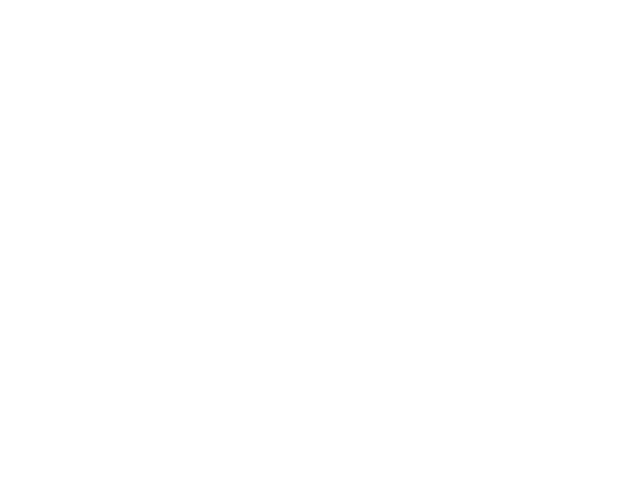

IndexError: boolean index did not match indexed array along dimension 0; dimension is 83 but corresponding boolean dimension is 55861

In [892]:
plt.figure()
plt.plot(gr[m],eh[m],'.')
plt.plot(gr[m],diff[m],'.',ms=1,alpha=.5)
plt.xlabel('')

67834

In [641]:
len(data)

83

In [419]:
np.percentile(diff16[m16],50) - np.percentile(diff2[m2],50)

-0.0278960078961763

In [237]:
grcal = data['g'].values-data['r'].values

<IPython.core.display.Javascript object>


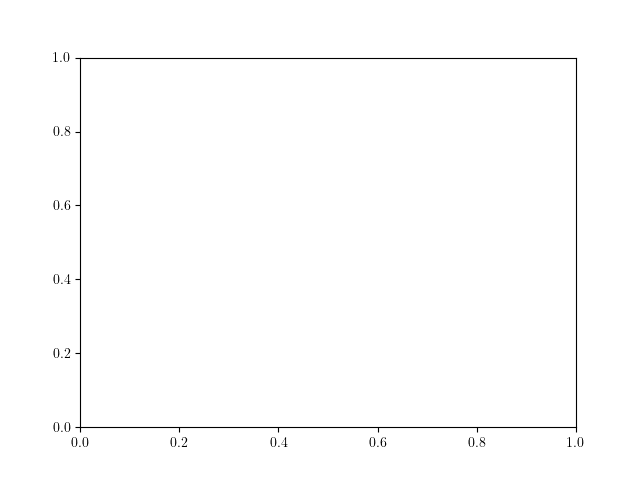

ValueError: x and y must have same first dimension, but have shapes (142299,) and (72387,)

In [259]:
plt.figure()
plt.plot((g-r),diff,'.')
#plt.plot(grcal,rdiff,'.')

# fit to PS1 obs data

In [177]:
def r_linear_combo(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    return fit 



def r_linear_combo2(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (.5*g + .5*i)*(g/i)**c[0]
    fit = -2.5*np.log10(fit) + 25
    return fit 

def r_minimizer(c,mag):
    k = data['r']
    fit = -2.5*np.log10(r_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

def r_minimizer2(c,mag):
    k = mag['r']
    fit = r_linear_combo2(c,mag)
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

In [178]:
len(c16['g'])

4787

In [180]:
c16

{'g': array([14.97459984, 15.7894001 , 15.9406004 , ..., 14.51889992,
        15.88920021, 14.92739964]),
 'r': array([14.26710033, 15.01249981, 15.39099979, ..., 14.02929974,
        15.38710022, 14.1480999 ]),
 'i': array([13.95100021, 14.69009972, 15.16660023, ..., 13.82979965,
        15.14360046, 13.8465004 ]),
 'z': array([13.83850002, 14.56820011, 15.10560036, ..., 13.74960041,
        15.05070019, 13.72550011])}

In [182]:
c0 = [.3,.3,.3,1]
bds = [(0,1),(0,1),(0,1),(-100,100)]
res2 = minimize(r_minimizer2,c0,args=c16,bounds=bds)

#c0 = [1]
#bds = [(-100,100)]
#res22 = minimize(r_minimizer2,c0,args=c16,bounds=bds)

In [183]:
data = r_comp(res2.x,c16,ext=med16)
#data2 = r_linear_combo2(res22.x,c16)
cal = r_comp(res.x,c16,ext=med16)

In [185]:
diff = c16['r']-cal
diff2 = c16['r']-data
#diff22 = c16['r']-data2
m = ~sigma_clip(diff2).mask & ~sigma_clip(diff).mask

<IPython.core.display.Javascript object>


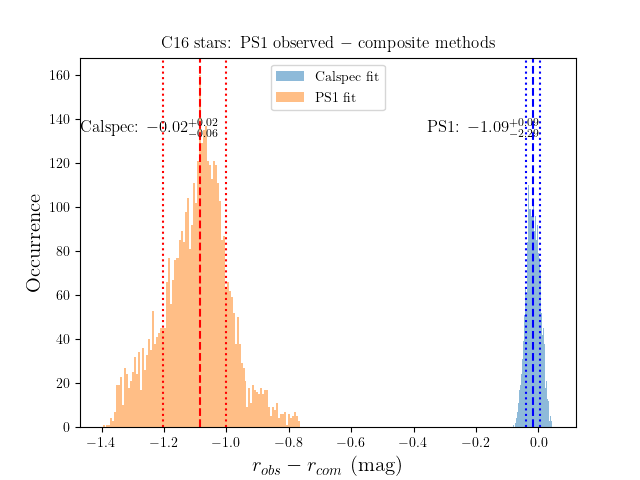

In [186]:
plt.figure()
plt.hist(diff[m],bins=100,alpha=.5,label='Calspec fit');
med = np.percentile(diff[m],50)
low = np.percentile(diff[m],16)
high = np.percentile(diff[m],84)

plt.axvline(med,ls='--',color='b')
plt.axvline(low,ls=':',color='b')
plt.axvline(high,ls=':',color='b')

s = 'Calspec: $'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(0.001,.8),fontsize=12,xycoords='axes fraction')

plt.hist(diff2[m],bins=100,alpha=.5,label='PS1 fit');
med = np.percentile(diff2[m],50)
low = np.percentile(diff2[m],16)
high = np.percentile(diff2[m],84)

plt.axvline(med,ls='--',color='r')
plt.axvline(low,ls=':',color='r')
plt.axvline(high,ls=':',color='r')

s = 'PS1: $'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.7,.8),fontsize=12,xycoords='axes fraction')


#plt.hist(diff22[m],bins=100,alpha=.5,label='PS1 observed');
plt.legend()
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mag)',fontsize=15)
plt.title('C16 stars: PS1 observed $-$ composite methods')
plt.savefig('calspecfit_vs_ps1datafit.png')

<IPython.core.display.Javascript object>


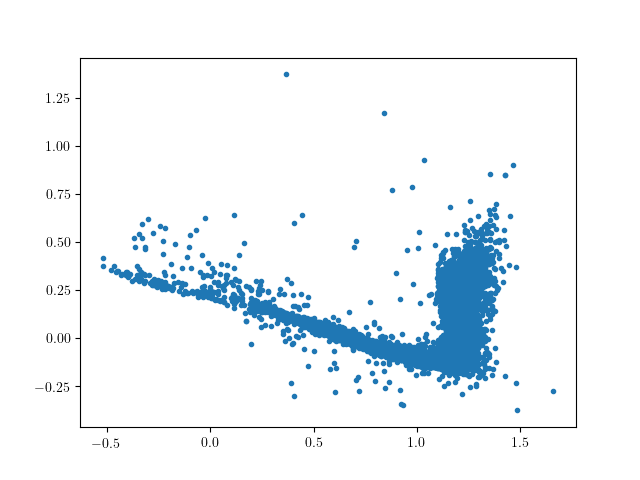

In [214]:
plt.figure()
plt.plot((g-r),diff,'.')